In [48]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader
from torchlake.text_classification.models import TextCnn
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

# setting


In [49]:
data_path = Path('../../data/childrenBooksAndStories')
artifacts_path = Path('../../artifacts/textcnn')

In [50]:
unk_idex = 0
bos_idx = 1
eos_idx = 2
padding_idx = 3
min_seq_len = 5
max_seq_len = 256

In [51]:
batch_size = 128
min_frequency = 5

In [52]:
tokenizer = get_tokenizer("basic_english")

In [53]:
data = pd.read_csv(
    data_path.joinpath("children_stories.csv").as_posix(),
    encoding="latin-1",
    usecols=["cats", "desc"],
)

In [54]:
#移除空標籤
data = data.query('cats != "Age "')

In [55]:
def convert_label(label: str) -> int:
    """convert age label to label

    Args:
        label (str): age label, in format like 'x-y', 'x+'

    Returns:
        int: 0 -> before kindergarten, 1 -> kindergarten, 2 -> elementary school
    """
    
    label = label.replace("6months", "0.5")
    
    if "-" in label:
        [lower, upper] = label.split("-")
        lower, upper = float(lower), float(upper)
    else:
        lower = float(label.replace("+", ""))
        upper = np.Inf

    if 3 >= lower:
        return 1
    elif 8 >= lower:
        return 2
    else:
        return 0

In [56]:
data['cats'] = data.cats.str.replace("Age\s", "", regex=True)

In [57]:
data['cats'] = data.cats.apply(convert_label)

In [58]:
data.cats.value_counts()

cats
1    179
2    146
0    103
Name: count, dtype: int64

In [59]:
train_data,test_data = train_test_split(data, test_size=1/5)

In [60]:
vocab = build_vocab_from_iterator(
    train_data['desc'].str.split(),
    specials=["<unk>", "<bos>", "<eos>", "<pad>"],
    min_freq=min_frequency,
)

vocab.set_default_index(vocab["<unk>"])

In [61]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(max_seq_len - 2),
    T.AddToken(token=bos_idx, begin=True),
    T.AddToken(token=eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(max_seq_len, padding_idx),
)

In [62]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []
    
    for label, text in batch:
        text = tokenizer(text)
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [63]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [64]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([128, 256]) torch.Size([128])


# model

In [65]:
vocab_size = len(vocab)
label_size = data.cats.nunique()

In [66]:
device = torch.device("cuda:0")

In [67]:
model = TextCnn(vocab_size, 128, label_size).to(device)

In [68]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
TextCnn                                  --
├─Embedding: 1-1                         119,552
├─TextCnnPool: 1-2                       --
│    └─ModuleList: 2-1                   --
│    │    └─Sequential: 3-1              8,224
│    │    └─Sequential: 3-2              12,320
│    │    └─Sequential: 3-3              16,416
├─Linear: 1-3                            291
Total params: 156,803
Trainable params: 156,803
Non-trainable params: 0

# train

In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [70]:
epoches = 20

In [71]:
model.train()
training_loss = []
for e in range(epoches):
    running_loss = 0.0

    for text, label in tqdm(train_iter):
        optimizer.zero_grad()

        text = text.to(device)
        label = label.to(device)

        output = model(text)

        loss = criterion(output, label.long())
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    training_loss.append(running_loss / len(train_data))

    print(f"epoch {e+1} : {running_loss / len(train_data)}")

100%|██████████| 3/3 [00:00<00:00,  9.13it/s]


epoch 1 : 0.011303715887125473


100%|██████████| 3/3 [00:00<00:00, 26.12it/s]


epoch 2 : 0.00895208503767761


100%|██████████| 3/3 [00:00<00:00, 30.31it/s]


epoch 3 : 0.008874702174761141


100%|██████████| 3/3 [00:00<00:00, 29.71it/s]


epoch 4 : 0.007925804944066276


100%|██████████| 3/3 [00:00<00:00, 27.38it/s]


epoch 5 : 0.007259571064285367


100%|██████████| 3/3 [00:00<00:00, 20.91it/s]


epoch 6 : 0.006984002060360379


100%|██████████| 3/3 [00:00<00:00, 28.35it/s]


epoch 7 : 0.006493866095068859


100%|██████████| 3/3 [00:00<00:00, 24.52it/s]


epoch 8 : 0.00596594862770616


100%|██████████| 3/3 [00:00<00:00, 26.16it/s]


epoch 9 : 0.005713775666833621


100%|██████████| 3/3 [00:00<00:00, 31.40it/s]


epoch 10 : 0.0053008610045003615


100%|██████████| 3/3 [00:00<00:00, 31.84it/s]


epoch 11 : 0.004934105782480965


100%|██████████| 3/3 [00:00<00:00, 32.11it/s]


epoch 12 : 0.004574972983689336


100%|██████████| 3/3 [00:00<00:00, 31.35it/s]


epoch 13 : 0.004286375920674954


100%|██████████| 3/3 [00:00<00:00, 26.39it/s]


epoch 14 : 0.003933582215281258


100%|██████████| 3/3 [00:00<00:00, 24.89it/s]


epoch 15 : 0.003653410843938415


100%|██████████| 3/3 [00:00<00:00, 26.65it/s]


epoch 16 : 0.0033478590480068276


100%|██████████| 3/3 [00:00<00:00, 28.54it/s]


epoch 17 : 0.0030907084893064887


100%|██████████| 3/3 [00:00<00:00, 26.18it/s]


epoch 18 : 0.0028547104339153445


100%|██████████| 3/3 [00:00<00:00, 27.48it/s]


epoch 19 : 0.002609434357860632


100%|██████████| 3/3 [00:00<00:00, 27.03it/s]

epoch 20 : 0.0023902888186493813


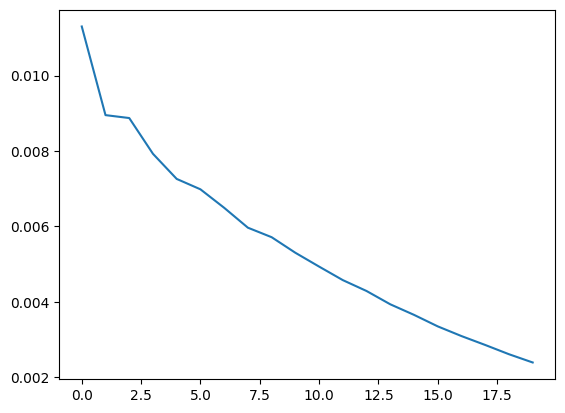

In [72]:
plt.plot(training_loss)

# inference

In [73]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    
    for text, label in tqdm(train_iter):
        text = text.cuda()
        label = label.cuda()
        
        output = model(text)
        
        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
        
    print(running_hit/len(train_data))

100%|██████████| 3/3 [00:00<00:00, 12.22it/s]

0.9970760233918129


In [74]:
model.eval()
with torch.no_grad():
    running_hit = 0.0
    
    for text, label in tqdm(test_iter):
        text = text.cuda()
        label = label.cuda()
        
        output = model(text)
        
        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()
        
    print(running_hit/len(test_data))

100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

0.7209302325581395


In [77]:
model_path = artifacts_path.joinpath("textcnn.pth")

In [78]:
torch.save(model.state_dict(), model_path)

In [79]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>